In [110]:
import random
import numpy as np
import matplotlib.pyplot as plt

import math
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from tests.quantlib_mult_cal import stock_prices

warnings.filterwarnings("ignore")
# plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
 
from scipy.stats import norm
from math import log, sqrt, pi, exp
from scipy import stats

In [111]:
def mcs_simulation(S0,r,b,T,sigma,paths,steps):
    """
    Monte Carlo Simulation, MCS
    S0:期初价格
    r:折现率
    b:持有成本，b=r就是标准的无股利，b=r-q就是有股利模型 ***
    T：到期期限
    sigma：波动率
    paths:路径数
    steps：模拟天数
    """
    dt = T/steps
    S_path = np.zeros((steps+1,paths))
    Time_path = np.zeros((steps+1,1))
    S_path[0] = S0
    Time_path[0] = 0
    for step in range(1,steps+1):
        rn = np.random.standard_normal(paths)
        S_path[step] = S_path[step - 1] * np.exp((b-0.5*sigma**2)*dt +sigma*np.sqrt(dt)*rn) #几何布朗运动的解
        Time_path[step] = step * dt
    return S_path, Time_path

In [112]:
#bs model 
def bsprice(s0,k,T,r,sig):
    """
    bs定价
    Black-Scholes price for a European call option.
    :param s0: 
    :param k: 
    :param T: 
    :param r: 
    :param sig: 
    :return: 
    """
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    option_price = s0 * stats.norm.cdf(d1) - k * np.exp(-r * T) * stats.norm.cdf(d2)
    return option_price
def bsdelta(s0,k,T,r,sig):
    """
    Delta of a European call option.
    Delta 的金融意义
    对冲比率：
    Delta 是动态对冲中需持有的标的资产数量。
    例如，Delta = 0.6 ⇒ 对冲 1 份期权需 0.6 股标的。
    价格敏感性：
    若标的资产价格上涨 1 元，期权价格约上涨 Delta × 1 元。
    ​看涨 vs 看跌期权：
    看涨期权 Delta ∈ [0, 1]。
    看跌期权 Delta ∈ [-1, 0]（公式为 N(d1)−1）。
    :param s0: 
    :param k: 
    :param T: 
    :param r: 
    :param sig: 
    :return: 
    """
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    delta = stats.norm.cdf(d1)
    return delta 

In [113]:
S = 1
T = 1
sigma = 0.13
r = 0.03
b = 0.03
Strike =  1
optionType = "C"

S = 100
T = 1
sigma = 0.13
r = 0.03
b = 0.03
Strike =  100
optionType = "C"

In [114]:
paths = 1000
steps = 252

# Parameters


## Case 2: Buy a call option, and then sell the Delta Stock for delta hedge

In [115]:
option_qty = 1
S_path, Time_path =  mcs_simulation(S,r,b,T,sigma,paths,steps)


In [116]:
S_path[-1].max(), S_path[-1].min(), S_path[-1].mean(), S_path[-1].std()

(155.50284071533528, 70.97872638724188, 103.02175704265778, 13.229532629025625)

In [132]:
pd.DataFrame(S_path).to_csv(f'../data/random_1000.csv')

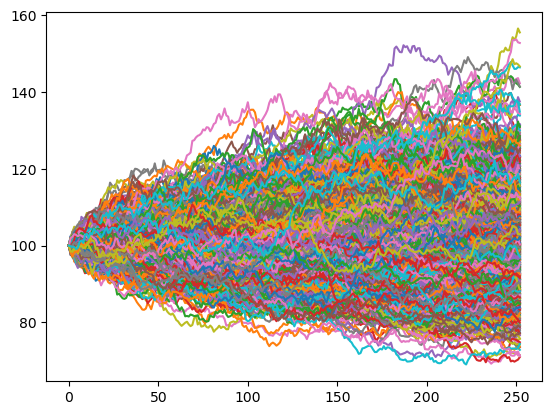

In [117]:
plt.plot(S_path)

In [118]:

CallPrice = bsprice(S_path,Strike,T-Time_path,r,sigma)
CallDelta = bsdelta(S_path,Strike,T-Time_path,r,sigma)
call_price0 = CallPrice[0,0]
delta0 = CallDelta[0,0]

In [119]:
dt = pd.DataFrame(Time_path).diff().values
dt[0,:] = 0.0

In [120]:

option_account_value = CallPrice * option_qty

In [121]:
underlying_hedge_account_value = option_qty * CallDelta * (-1) * S_path
underlying_hedge_account_qty = option_qty * CallDelta * (-1) 

In [122]:
delta_rebalance_qty = pd.DataFrame(underlying_hedge_account_qty).diff().values
delta_rebalance_qty[0,:] = underlying_hedge_account_value[0,:]
delta_rebalance_notional = delta_rebalance_qty * S_path

In [123]:
bank_account_value = np.zeros((steps+1,paths))
bank_account_value[0, :] = (-1)*(underlying_hedge_account_value[0,:] + option_account_value[0,:])

for i in range(1,len(bank_account_value)):
    bank_account_value[i, :] = bank_account_value[i-1,:] * (np.exp(r*dt[i,:])) - delta_rebalance_notional[i,:]

In [124]:
total_value_portfolio = option_account_value + underlying_hedge_account_value  + bank_account_value

In [125]:
S_path[0,0], CallPrice[0,0], CallDelta[0,0]

(100.0, 6.718894443206693, 0.6162968387467246)

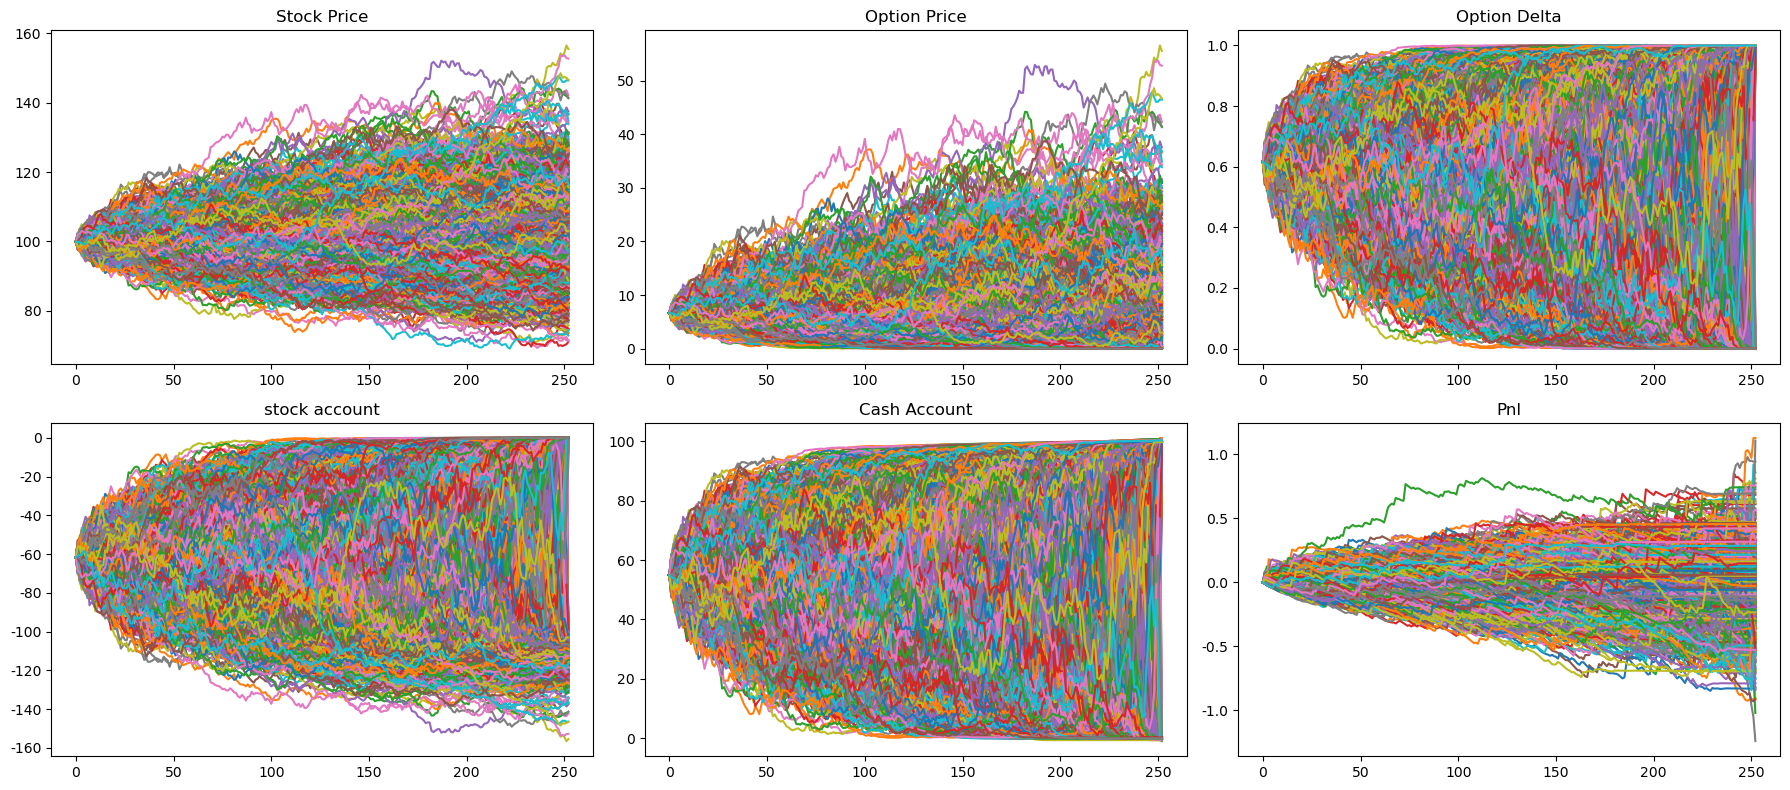

In [126]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(S_path)
ax[0, 0].set_title('Stock Price')

ax[0, 1].plot(CallPrice)
ax[0, 1].set_title('Option Price')

ax[0, 2].plot(CallDelta)
ax[0, 2].set_title('Option Delta')

ax[1, 0].plot(underlying_hedge_account_value)
ax[1, 0].set_title('stock account')

ax[1, 1].plot(bank_account_value)
ax[1, 1].set_title('Cash Account')

ax[1, 2].plot(total_value_portfolio)
ax[1, 2].set_title('Pnl')

plt.tight_layout()
plt.show()

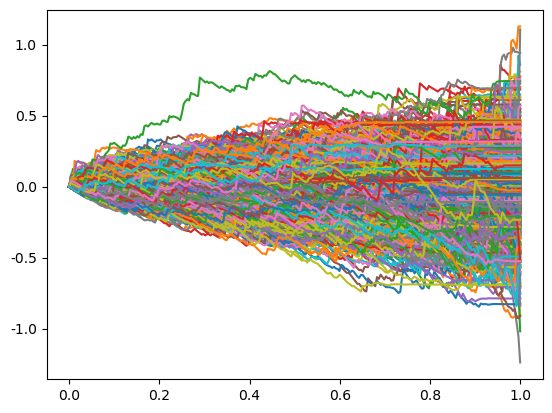

In [127]:
plt.plot(Time_path, total_value_portfolio)

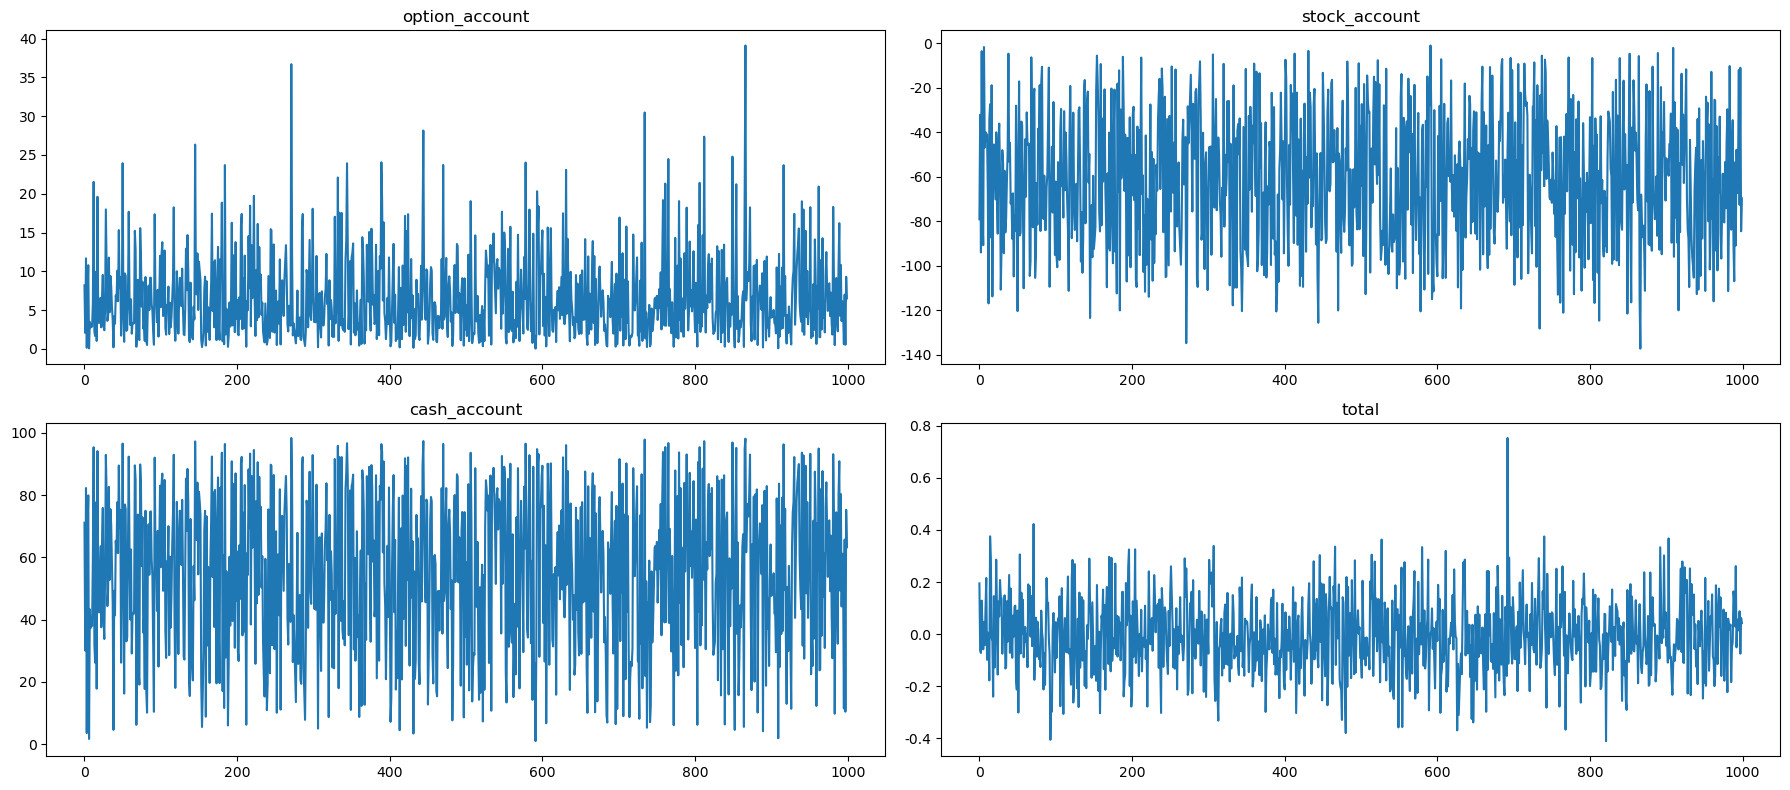

In [135]:
i = 100

op = option_account_value[i]
stock = underlying_hedge_account_value[i]
bank = bank_account_value[i]
total = total_value_portfolio[i]

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

ax[0, 0].plot(op)
ax[0, 0].set_title('option_account')

ax[0, 1].plot(stock)
ax[0, 1].set_title('stock_account')

ax[1, 0].plot(bank)
ax[1, 0].set_title('cash_account')

ax[1, 1].plot(op+stock+bank)
ax[1, 1].set_title('total')


plt.tight_layout()
plt.show()

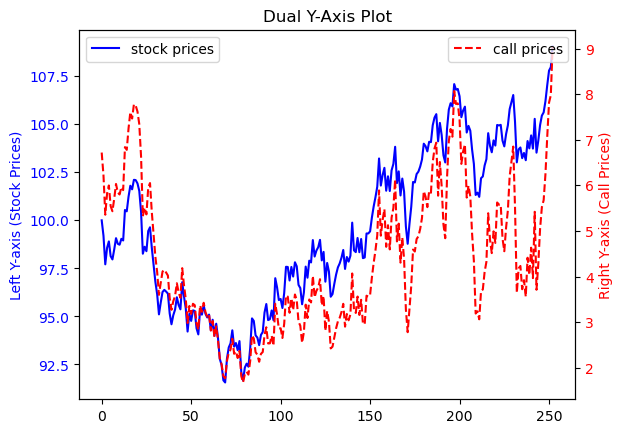

In [142]:
i = 10
# Create figure and first axis
fig, ax1 = plt.subplots()
ax1.plot(S_path[:,i], 'b-', label='stock prices')
ax1.set_ylabel('Left Y-axis (Stock Prices)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(CallPrice[:, i], 'r--', label='call prices')
ax2.set_ylabel('Right Y-axis (Call Prices)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends and title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Dual Y-Axis Plot')
plt.show()

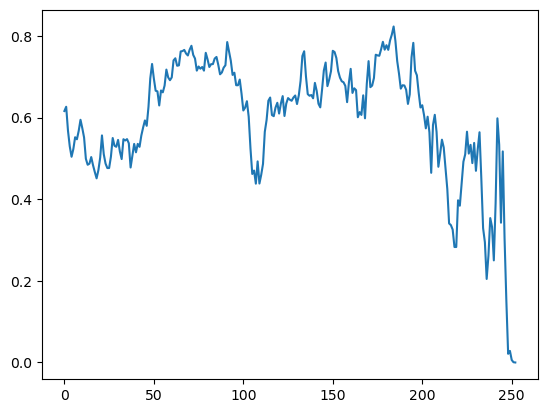

In [141]:
plt.plot(CallDelta[:,i])
plt.show()